# SimpleRNN 을 이용한 SMS Spam 분류
## - Kaggle의 스팸메일 데이터(https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [1]:
import numpy as np
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('data/spam.csv', encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 데이터 전처리

In [12]:
df = df.iloc[:,0:2]
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [15]:
df['v1'] = df.v1.replace(['ham','spam'],[0,1])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [17]:
# Null 값이 있는지 확인
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [18]:
# 데이터 중복 여부
df.v2.nunique()

5169

In [19]:
# 중복 데이터 제거
df = df.drop_duplicates('v2', keep='first')

In [20]:
# Ham/Spam 데이터 갯수 확인
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [27]:
# X, y 데이터 지정
X_data = df.v2.values
y_data = df.v1.values
len(X_data), y_data.shape

(5169, (5169,))

In [28]:
type(X_data)

numpy.ndarray

In [29]:
X_data

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
       'Rofl. Its true to its name'], dtype=object)

In [23]:
# 구둣점 제거, 소문자로 변환
from string import punctuation

def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    return ''.join(c for c in s if c not in punctuation).lower()

In [30]:
X_data = [preprocessing(s) for s in X_data]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [31]:
# 단어 집합을 만들고, 그 크기를 확인
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
vocab_size

9480

In [33]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3838, 84, 3839, 424, 3840]


In [34]:
max_len = max(len(l) for l in sequences)
max_len

171

In [35]:
# 전체 데이터셋의 길이를 max_len(171)에 맞추기
data = pad_sequences(sequences, maxlen=max_len)
data.shape

(5169, 171)

In [38]:
data[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(
    data, y_data, stratify=y_data, test_size=0.2, random_state=seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

## 모델 정의/설정/학습

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [42]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 32)           303360    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 305,473
Trainable params: 305,473
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

In [44]:
history = model.fit(X_train, y_train, epochs=10,
                     batch_size=60, validation_split=0.2, verbose=2)

Epoch 1/10
56/56 - 2s - loss: 0.4089 - accuracy: 0.8643 - val_loss: 0.3347 - val_accuracy: 0.8948
Epoch 2/10
56/56 - 1s - loss: 0.1725 - accuracy: 0.9550 - val_loss: 0.0915 - val_accuracy: 0.9794
Epoch 3/10
56/56 - 1s - loss: 0.0738 - accuracy: 0.9813 - val_loss: 0.0760 - val_accuracy: 0.9819
Epoch 4/10
56/56 - 1s - loss: 0.0366 - accuracy: 0.9918 - val_loss: 0.0641 - val_accuracy: 0.9831
Epoch 5/10
56/56 - 1s - loss: 0.0167 - accuracy: 0.9979 - val_loss: 0.0666 - val_accuracy: 0.9843
Epoch 6/10
56/56 - 1s - loss: 0.0101 - accuracy: 0.9988 - val_loss: 0.0663 - val_accuracy: 0.9843
Epoch 7/10
56/56 - 1s - loss: 0.0093 - accuracy: 0.9985 - val_loss: 0.0698 - val_accuracy: 0.9831
Epoch 8/10
56/56 - 1s - loss: 0.0066 - accuracy: 0.9991 - val_loss: 0.0723 - val_accuracy: 0.9843
Epoch 9/10
56/56 - 1s - loss: 0.0047 - accuracy: 0.9994 - val_loss: 0.0728 - val_accuracy: 0.9843
Epoch 10/10
56/56 - 1s - loss: 0.0054 - accuracy: 0.9991 - val_loss: 0.0719 - val_accuracy: 0.9819


In [45]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 5ms/step - loss: 0.0552 - accuracy: 0.9826


[0.05519111827015877, 0.9825918674468994]

## 학습과정 시각화

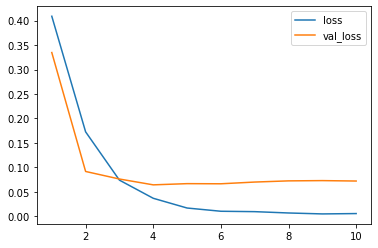

In [47]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = range(1, len(y_loss)+1)
plt.plot(x_len, y_loss, label='loss')
plt.plot(x_len, y_vloss, label='val_loss')
plt.legend()
plt.show()